### Predict tags on StackOverflow with linear models

We will learn how to predict tags for posts from StackOverflow. To solve this task you will use multilabel classification approach.


### Import Libraries

The list of stop words is downloaded from nltk

In [257]:
import pandas as pd
pd.set_option('max_colwidth',-1)
import numpy as np
import nltk, re
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Georgios.Drakos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [292]:
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

In [259]:
dataset = pd.read_csv('train.csv')
print(dataset.shape)
dataset.sample(5)

(100000, 2)


,title,tags
52549,Does python have header files like C/C++?,"['python', 'python-2.7', 'python-3.x']"
112,"Automatically install toolbarbutton to firefox nav-bar, not working with insertItem",['javascript']
22421,Can the input and output strings to sprintf() be the same?,['c']
32003,Download JSON file via JavaScript/JQuery - HTTP-Status Ok - JQuery Error,"['javascript', 'jquery', 'ajax', 'json']"
86862,Calculate the Cumulative Distribution Function (CDF) in Python,"['python', 'numpy']"


As you can see, title column contains titles of the posts and tags colum countains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

Split the dataset to train and test dataset.

In [260]:
X_train, X_test, y_train, y_test = train_test_split(dataset['title'].values, dataset['tags'].values, test_size=0.3, random_state=42)

### Text Preprocessing

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens.To prevent the problems, it's usually useful to prepare the data somehow. 

In [261]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list((stopwords.words('english')))

def text_prepare(text,join_sumbol):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text,)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = re.sub(r'\s+'," ",text)
    # delete stopwords from text
    text = f'{join_sumbol}'.join([i for i in text.split() if i not in STOPWORDS])
    
    return text

In [262]:
tests = ["SQL Server - any equivalent of Excel's CHOOSE function?",
        "How to free c++ memory vector<int> * arr?"]
for test in tests: print(text_prepare(test,' '))

sql server equivalent excels choose function
free c++ memory vectorint arr


Now we can preprocess the titles using function text_prepare and making sure that the titles and tags don't have bad symbols:

In [263]:
X_train = [text_prepare(x,' ') for x in X_train]
X_test = [text_prepare(x,' ') for x in X_test]
y_train = [text_prepare(x,',') for x in y_train]
y_test = [text_prepare(x,',') for x in y_test]

In [264]:
X_train[:20]

['jquery dynamically load image working showing multipule images replace src append',
 'handling null results linq average method',
 'setting multiple environmental variables',
 'c++ passing const string references methods',
 'javascript get src specific image onclick',
 'create asmx web service page without code behind file',
 'responsesendredirect working spring mvc requestmethoddelete',
 'mailmessagebody loses crlf encodingutf8',
 'spring requestparam class',
 'jquery ui accordion add icon right',
 'convert pdf jpg image php',
 'set custom font uilabel storyboard',
 'convert existing eclipse project maven project',
 'select onchange event',
 'generate next auto increment number mysql using php',
 'faulting module name clrdll version 4030319544',
 'convert li elements div',
 'matplotlib google app engine',
 'select multiple columns using entity framework',
 'escape sequence c']

In [265]:
y_train[:20]

['javascript,jquery,html,image',
 'c#,net,linq',
 'java,net',
 'c++',
 'javascript,html',
 'c#,aspnet',
 'java,springmvc',
 'c#,vbnet,string',
 'java,spring,hibernate',
 'javascript,jquery,html,css',
 'php',
 'ios,objectivec,iphone',
 'java,eclipse',
 'javascript,jquery,html',
 'php,mysql',
 'c#,net',
 'javascript,jquery,ajax',
 'python',
 'c#,net,entityframework',
 'c']

### EDA: Find 3 most popular tags and 3 most popular words in the train dataset.

In [266]:
from collections import Counter
from itertools import chain

# Dictionary of all tags from train corpus with their counts.
tags_counts = Counter(chain.from_iterable([i.split(",") for i in y_train]))

# Dictionary of all words from train corpus with their counts.
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

top_3_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"Top three most popular tags are: {','.join(tag for tag, _ in top_3_most_common_tags)}")
print(f"Top three most popular words are: {','.join(tag for tag, _ in top_3_most_common_words)}")

Top three most popular tags are: javascript,c#,java
Top three most popular words are: using,php,java


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this article we will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data.

In [267]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    keys= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[keys]=1
    return result_vector

Now apply the implemented function to all samples (this might take up to a minute):

In [268]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (70000, 5000)
X_test shape  (30000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many types of such representations, however slkearn algorithms can work only with csr matrix, so we will use this one.

In [269]:
row = X_train_mybag[10].toarray()[0]
non_zero_indexes = np.nonzero(row)[0].shape[0]
print(non_zero_indexes,row.shape)
row

5 (5000,)


array([0., 1., 0., ..., 0., 0., 0.])

**TF-IDF**

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space.

We use TfidfVectorizer from scikit-learn and our train corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. I filter out too rare words (occur less than 5) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in our vocabulary.

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return bag-of-words representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(X_train,ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' )
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it.

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [271]:
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [272]:
X_test_tfidf[1]

<1x13054 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [273]:
print("c#" in set(tfidf_reversed_vocab.values()))
print("c++" in set(tfidf_reversed_vocab.values()))

True
True


### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use MultiLabelBinarizer from sklearn.

In [274]:
from sklearn.preprocessing import MultiLabelBinarizer

In [275]:
y_train[0]

'javascript,jquery,html,image'

In [276]:
y_train = [set(i.split(',')) for i in y_train]
y_test = [set(i.split(',')) for i in y_test]

In [277]:
y_train[0]

{'html', 'image', 'javascript', 'jquery'}

In [278]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.fit_transform(y_test)

In [279]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [280]:
mlb.classes_

array(['ajax', 'algorithm', 'android', 'angularjs', 'apache', 'arrays',
       'aspnet', 'aspnetmvc', 'c', 'c#', 'c++', 'class', 'cocoatouch',
       'codeigniter', 'css', 'csv', 'database', 'date', 'datetime',
       'django', 'dom', 'eclipse', 'entityframework', 'excel', 'facebook',
       'file', 'forms', 'function', 'generics', 'googlemaps', 'hibernate',
       'html', 'html5', 'image', 'ios', 'iphone', 'java', 'javascript',
       'jquery', 'json', 'jsp', 'laravel', 'linq', 'linux', 'list',
       'loops', 'maven', 'mongodb', 'multithreading', 'mysql', 'net',
       'nodejs', 'numpy', 'objectivec', 'oop', 'opencv', 'osx', 'pandas',
       'parsing', 'performance', 'php', 'pointers', 'python', 'python27',
       'python3x', 'qt', 'r', 'regex', 'rest', 'ruby', 'rubyonrails',
       'rubyonrails3', 'selenium', 'servlets', 'session', 'sockets',
       'sorting', 'spring', 'springmvc', 'sql', 'sqlserver', 'string',
       'swift', 'swing', 'twitterbootstrap', 'uitableview', 'unittestin

In this task we suggest to use One-vs-Rest approach, which is implemented in OneVsRestClassifier class. In this approach k classifiers (= number of tags) are trained. As a basic classifier, use LogisticRegression. It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because the number of classifiers to train is large.

In [281]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1.0)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='lda':
        model = LinearDiscriminantAnalysis(solver='svd')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model

# Train the classifiers for different data transformations: bag-of-words and tf-idf.

# Linear NLP model using bag of words approach
%time classifier_mybag = train_classifier(X_train_mybag, y_train, C=1.0, model='lr')

# Linear NLP model using TF-IDF approach
%time classifier_tfidf = train_classifier(X_train_tfidf, y_train, C=1.0, model='lr')

CPU times: user 16.3 s, sys: 305 ms, total: 16.6 s
Wall time: 19.2 s
CPU times: user 16.1 s, sys: 422 ms, total: 16.6 s
Wall time: 19.7 s



Train the classifiers for different data transformations: bag-of-words and tf-idf.

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [282]:
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)

y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)


Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [283]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	making auto timeout stdcin statement
True labels:	c++,linux,multithreading
Predicted labels:	


Title:	penalty using char variables cuda kernels
True labels:	c,c++,performance
Predicted labels:	c,c++


Title:	sqlalchemy trying eager loading attribute error
True labels:	python
Predicted labels:	python




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure.

### Evaluation
To evaluate the results we will use several classification metrics:

* Accuracy
* F1-score
* Area under ROC-curve
* Area under precision-recall curve

In [284]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


Implement the function print_evaluation_scores which calculates and prints out:

accuracy
F1-score macro/micro/weighted
Precision macro/micro/weighted

In [285]:
from functools import partial
def print_evaluation_scores(y_val, predicted):
    f1_score_macro = partial(f1_score,average="macro")
    f1_score_micro = partial(f1_score,average="micro")
    f1_score_weighted = partial(f1_score,average="weighted")
    
    average_precision_score_macro = partial(average_precision_score,average="macro")
    average_precision_score_micro = partial(average_precision_score,average="micro")
    average_precision_score_weighted = partial(average_precision_score,average="weighted")
    
    scores = [accuracy_score,f1_score_macro,f1_score_micro,f1_score_weighted,average_precision_score_macro,
             average_precision_score_micro,average_precision_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

In [286]:
print('Bag-of-words')
print_evaluation_scores(y_test, y_test_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Bag-of-words
<function accuracy_score at 0x123c0e488> 0.3596
functools.partial(<function f1_score at 0x123c0e7b8>, average='macro') 0.5175463713168731
functools.partial(<function f1_score at 0x123c0e7b8>, average='micro') 0.6737210482175953
functools.partial(<function f1_score at 0x123c0e7b8>, average='weighted') 0.6519391654354657
functools.partial(<function average_precision_score at 0x123bfcd90>, average='macro') 0.35645080184508493
functools.partial(<function average_precision_score at 0x123bfcd90>, average='micro') 0.4827362533826876
functools.partial(<function average_precision_score at 0x123bfcd90>, average='weighted') 0.5123503606366472
Tfidf
<function accuracy_score at 0x123c0e488> 0.3526
functools.partial(<function f1_score at 0x123c0e7b8>, average='macro') 0.5072146350993542
functools.partial(<function f1_score at 0x123c0e7b8>, average='micro') 0.6657673134281168
functools.partial(<function f1_score at 0x123c0e7b8>, average='weighted') 0.6438481324951042
functools.partial(<f

### HyperParameter Tuning

We will use F1-score weighted as an evaluation metric, try L1 and L2-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

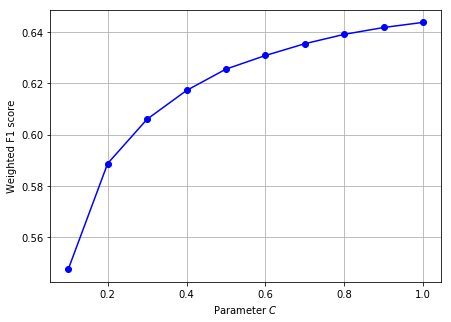

In [288]:
import matplotlib.pyplot as plt

hypers = np.arange(0.1, 1.1, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(X_train_tfidf, y_train, C=h, model='lr')
    temp_pred = f1_score(y_test, temp_model.predict(X_test_tfidf), average='weighted')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

We fit the "best" model and create predictions for test set when we are happy with the quality:

In [289]:
# Final model
C = 1.0
classifier = train_classifier(X_train_tfidf, y_train, C=C, model='lr')

# Results
test_predictions =  classifier.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_pred_inversed

[(),
 ('c', 'c++'),
 ('python',),
 ('javascript', 'twitterbootstrap'),
 ('javascript', 'jquery'),
 ('mysql', 'php'),
 (),
 ('javascript', 'jquery'),
 ('php',),
 (),
 ('laravel', 'php'),
 (),
 ('javascript',),
 ('javascript',),
 ('c#', 'java'),
 ('javascript',),
 ('c#',),
 ('java',),
 (),
 ('java',),
 (),
 ('ruby', 'rubyonrails', 'validation'),
 ('css', 'javascript', 'twitterbootstrap'),
 ('html', 'javascript'),
 (),
 ('c',),
 ('c#', 'linq'),
 ('javascript',),
 ('ios', 'objectivec', 'xcode'),
 ('python',),
 ('java',),
 ('php',),
 (),
 ('database', 'mysql', 'php'),
 ('laravel', 'php'),
 ('mysql', 'php'),
 ('rubyonrails',),
 ('css', 'regex'),
 ('c#', 'json'),
 ('c++', 'windows'),
 ('objectivec',),
 ('mysql', 'php'),
 ('database', 'django', 'python'),
 ('ios', 'swift'),
 ('javascript',),
 (),
 (),
 (),
 ('html', 'java', 'javascript'),
 ('string',),
 (),
 ('c++',),
 (),
 ('xml',),
 ('php',),
 ('sockets',),
 (),
 ('javascript', 'jquery'),
 ('c#', 'visualstudio2010'),
 ('javascript', 'jquery'

### Feature Importance

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

In [290]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    tag_n = np.where(tags_classes==tag)[0][0]
    
    model = classifier.estimators_[tag_n]
    top_positive_words = [index_to_words[x] for x in model.coef_.argsort().tolist()[0][-8:]]
    top_negative_words = [index_to_words[x] for x in model.coef_.argsort().tolist()[0][:8]]
    
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [291]:
print_words_for_tag(classifier, 'c', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier, 'c++', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier, 'linux', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier, 'python', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier, 'r', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier, 'java', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	fork, gtk, fscanf, kernel, printf, scanf, malloc, c
Top negative words:	php, python, javascript, java, c#, objective, jquery, swift

Tag:	c++
Top positive words:	c++11, boostasio, mfc, stl, stdstring, boost, qt, c++
Top negative words:	php, java, javascript, python, c#, jquery, objectivec, swift

Tag:	linux
Top positive words:	address, shared, ubuntu, centos, killed, cron, kernel space, linux
Top negative words:	javascript, c#, jquery, array, method, windows, value, string

Tag:	python
Top positive words:	beautifulsoup, flask, sqlalchemy, tkinter, matplotlib, numpy, pandas, python
Top negative words:	php, c#, java, django python, javascript, jquery, r, c++

Tag:	r
Top positive words:	rs, data frame, dplyr, shiny, rstudio, ggplot, ggplot2, r
Top negative words:	python, android, php, java, javascript, pandas, c#, n

Tag:	java
Top positive words:	tomcat, jtable, javafx, android, jar, hibernate, spring, java
Top negative words:	php, python, c#, rails, django, rub